# Wide Linear Neural Networks Preserve Feature Geometry

We have theoretically established that sufficiently wide linear neural networks cannot alter the geometry of the features. In this notebook, we perform experiments to empirically validate these theoretical predictions. We begin by importing the necessary libraries.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Helper Functions

In [ ]:
def lower_bound_m(n, delta, epsilon):
    """Calculate lower bound on network width established in Theorem 3.1.

    Args:
        n (int): numper of points.
        delta (float): Probability bound.
        epsilon (float): Seperation of neighborhoods.

    Returns:
        float: Lower bound on network width.
    """
    return 4 * (np.log(n*(n-1)) - np.log(delta)) / (epsilon**2 - epsilon**3)

In [ ]:
def kth_gap(X, k):
    """Function to compute the maximum epsilon satisfying the conditions in Theorem 3.1.

    Args:
        X (np.array): The point cloud.
        k (int): Number of neighbors in kNN graph.

    Returns:
        float: Epsilon.
    """
    # Compute all pairwise squared distances
    dists_square = np.square(cdist(X, X, metric='euclidean'))
    np.fill_diagonal(dists_square, np.inf) 

    # Partially sort to find the k+1 smallest distances
    kth_and_next_indices = np.argpartition(dists_square, k+1, axis=1)[:, :k+1]
    kth_and_next_distances = np.take_along_axis(dists_square, kth_and_next_indices, axis=1)

    # Sort only the k+1 distances
    kth_and_next_distances.sort(axis=1)
    
    # compute epsilon
    kth_distance = kth_and_next_distances[:, k-1]
    kplus1_distance = kth_and_next_distances[:, k]
    return ((kplus1_distance - kth_distance) / (kplus1_distance + kth_distance)).min()

In [ ]:
def r_neighborhood_graph_gap(X, r):
    """Function to compute the maximum epsilon satisfying the conditions in Theorem A.6.

    Args:
        X (Point): The point cloud.
        r (_type_): Parameter for construction of r-neighborhood graph.
    Returns:
        float: Gap.
    """
    # Compute all pairwise distances
    dists = cdist(X, X,metric='euclidean')
    
    # Keep only distances greater than r
    dists_above_r = dists[dists > r]

    # Keep only distances greater than r
    dists_below_r = dists[dists < r]
    
    return min((dists_above_r.min()**2 - r**2)/dists_above_r.min()**2, (r**2 - dists_below_r.max()**2)/dists_below_r.max()**2)

In [ ]:
def r_neighborhood_graph(X, r):
    """Function to construct a r-neighborhood graph on the point cloud X.

    Args:
        X (np.array): The point cloud.
        r (float): Parameter for construction of r-neighborhood graph.
    Returns:
        np.array: Adjacency Matrix.
    """
    # Compute all pairwise Euclidean distances
    dists = cdist(X, X, metric='euclidean')
    
    # Create adjacency matrix: connect points within distance epsilon
    A = (dists < r).astype(int)
    
    # Remove self-loops
    np.fill_diagonal(A, 0)
    
    return A

In [ ]:
def compare_kNN_graphs(X, A, k):
    """Function to construct a k-nearest-neighbor graph on the point clouds X and AX and compare if the resulting graphs are identical.

    Args:
        X (np.array): The point cloud.
        A (np.array): The linear transformation A.
        k (int): Parameter for construction of the k-nearest neighbor graph.

    Returns:
        Bool: True if the k-nearest neighbor graphs coincide.
    """
    AX = X @ A.T
    knn_X = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False).toarray()
    knn_AX = kneighbors_graph(AX, n_neighbors=k, mode='connectivity', include_self=False).toarray()
    if (knn_X == knn_AX).sum() == len(X)**2:
        return True
    else:
        return False

In [ ]:
def compare_r_neighborhood_graphs(X, A, r):
    """Function to construct a k-nearest-neighbor graph on the point clouds X and AX and compare if the resulting graphs are identical.

    Args:
        X (np.array): The point cloud.
        A (np.array): The linear transformation A.
        k (int): Parameter for construction of the k-nearest neighbor graph.

    Returns:
        Bool: True if the k-nearest neighbor graphs coincide.
    """
    AX = X @ A.T
    geometric_graph_X = r_neighborhood_graph(X, r)
    geometric_graph_AX = r_neighborhood_graph(AX, r)
    if (geometric_graph_X == geometric_graph_AX).sum() == len(X)**2:
        return True
    else:
        return False

# 3d-Unit Ball

In [100]:
def sample_unit_ball_3d(n):
    """Generate uniform samples from 3-d unit ball

    Args:
        n (int): Number of samples

    Returns:
        np.array: Samples
    """
    r = np.random.rand(n)  # radius
    phi = np.random.uniform(0, np.pi, n)
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = r * np.sin(phi) * np.cos(theta), 
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return np.vstack((x, y, z)).T

In [ ]:
# Sample points
X = sample_unit_ball_3d(n=50)
gap_knn, gap_r_neigh = kth_gap(X=X,k=5), r_neighborhood_graph_gap(X=X,r=0.3)
gap_knn, gap_r_neigh

(np.float64(0.0006708023678081252), np.float64(0.002515934846067874))

In [ ]:
# Calculate lower bounds on width according to theoretical results
lower_bound_m(n=50, delta=0.05, epsilon=gap_knn), lower_bound_m(n=50, delta=0.05, epsilon=gap_r_neigh)

(np.float64(96065827.72432835), np.float64(6841667.003222341))

In [ ]:
# Experimentally varify theoretical results
success_rate_kNN = []
success_rate_r_neigh= []
num_iterations = 1000

for i in range(1,20):
    sqrt_m = 50 * i
    print(sqrt_m)
    avg_kNN = 0
    avg_r_neigh = 0
    for _ in tqdm(range(num_iterations)):
        # Initialize random matrix
        A = np.random.normal(0, 1/sqrt_m, size=(sqrt_m**2,3))
        # Compare kNN graphs
        if compare_kNN_graphs(X=X, A=A, k=5):
            avg_kNN +=1
        # Compare r-neighborhood graphs
        if compare_r_neighborhood_graphs(X=X, A=A,r=0.3):
            avg_r_neigh+=1

    print(avg_kNN/num_iterations, avg_r_neigh/num_iterations)
    success_rate_kNN.append(avg_kNN/num_iterations)
    success_rate_r_neigh.append(avg_r_neigh/num_iterations)

50


100%|██████████| 1000/1000 [00:02<00:00, 469.58it/s]


0.044 0.205
100


100%|██████████| 1000/1000 [00:06<00:00, 145.31it/s]


0.232 0.631
150


100%|██████████| 1000/1000 [00:14<00:00, 71.36it/s]


0.517 0.89
200


100%|██████████| 1000/1000 [00:24<00:00, 40.49it/s]


0.711 0.968
250


100%|██████████| 1000/1000 [00:41<00:00, 24.19it/s]


0.792 0.997
300


100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]


0.892 0.999
350


100%|██████████| 1000/1000 [01:21<00:00, 12.33it/s]


0.938 1.0
400


100%|██████████| 1000/1000 [01:45<00:00,  9.47it/s]


0.957 0.999
450


100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


0.978 1.0
500


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


0.996 1.0
550


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]


0.995 1.0
600


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


0.997 1.0
650


100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]


0.999 1.0
700


100%|██████████| 1000/1000 [05:40<00:00,  2.93it/s]


0.998 1.0
750


100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]


1.0 1.0
800


100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


1.0 1.0
850


100%|██████████| 1000/1000 [08:19<00:00,  2.00it/s]


1.0 1.0
900


100%|██████████| 1000/1000 [09:22<00:00,  1.78it/s]


1.0 1.0
950


100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]

1.0 1.0


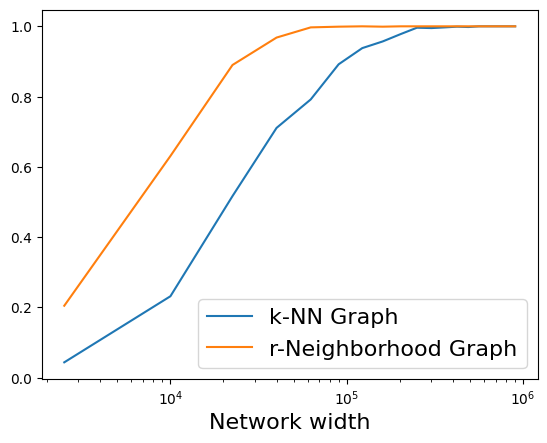

In [ ]:
# Plot results
plt.plot(np.square(np.arange(1,20)* 50), success_rate_kNN, label='k-NN Graph')
plt.plot(np.square(np.arange(1,20)* 50), success_rate_r_neigh, label='r-Neighborhood Graph')
plt.xscale('log')
plt.xlabel('Network width', fontsize=16)
plt.legend(fontsize=16)

# 2d-Unit Disc

In [ ]:
def sample_unit_ball_2d(n):
    """Generate uniform samples from 2-d unit ball.

    Args:
        n (int): Number of samples.

    Returns:
        np.array: Samples.
    """
    r = np.random.rand(n) 
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = r * np.cos(theta), 
    y = r * np.sin(theta)
    return np.vstack((x, y)).T

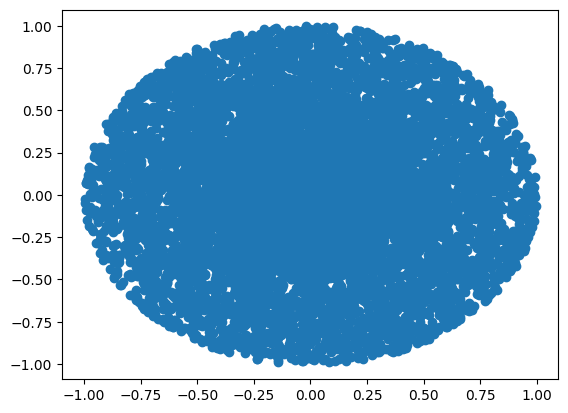

In [ ]:
# Plot samples
X = sample_unit_ball_2d(n=10000)
plt.scatter(X[:,0], X[:,1])

In [ ]:
# Generate samples
X = sample_unit_ball_2d(n=50)
gap_knn, gap_r_neigh =kth_gap(X=X,k=5), r_neighborhood_graph_gap(X=X,r=0.3)
gap_knn, gap_r_neigh

(np.float64(0.0007216847182611977), np.float64(0.00016579274829606698))

In [ ]:
# Calculate lower bounds on width according to theoretical results
lower_bound_m(n=50, delta=0.05, epsilon=gap_knn), lower_bound_m(n=50, delta=0.05, epsilon=gap_r_neigh)

(np.float64(83001357.97919208), np.float64(1571837431.1583257))

In [ ]:
# Experimentally varify theoretical results
success_rate_kNN = []
success_rate_r_neigh = []
num_iterations = 100

for i in range(1,20):
    sqrt_m = 50 * i
    print(sqrt_m)
    avg_kNN = 0
    avg_r_neigh = 0
    for _ in tqdm(range(num_iterations)):
        # Initialize random matrix
        A = np.random.normal(0, 1/sqrt_m, size=(sqrt_m**2,2))

        # Compare kNN graphs
        if compare_kNN_graphs(X=X, A=A, k=5):
            avg_kNN +=1

        # Compare r-neighborhood graphs
        if compare_r_neighborhood_graphs(X=X, A=A,r=0.3):
            avg_r_neigh+=1

    print(avg_kNN/num_iterations, avg_r_neigh/num_iterations)
    success_rate_kNN.append(avg_kNN/num_iterations)
    success_rate_r_neigh.append(avg_r_neigh/num_iterations)

50


100%|██████████| 100/100 [00:00<00:00, 371.72it/s]


0.34 0.28
100


100%|██████████| 100/100 [00:00<00:00, 128.47it/s]


0.5 0.61
150


100%|██████████| 100/100 [00:01<00:00, 69.93it/s]


0.71 0.81
200


100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


0.79 0.8
250


100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


0.83 0.87
300


100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


0.85 0.91
350


100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


0.86 0.91
400


100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


0.93 0.96
450


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


0.99 0.99
500


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


0.98 0.98
550


100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


0.98 1.0
600


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


0.99 1.0
650


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


0.99 1.0
700


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


1.0 1.0
750


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


1.0 1.0
800


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


1.0 1.0
850


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


1.0 1.0
900


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


1.0 1.0
950


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

1.0 1.0


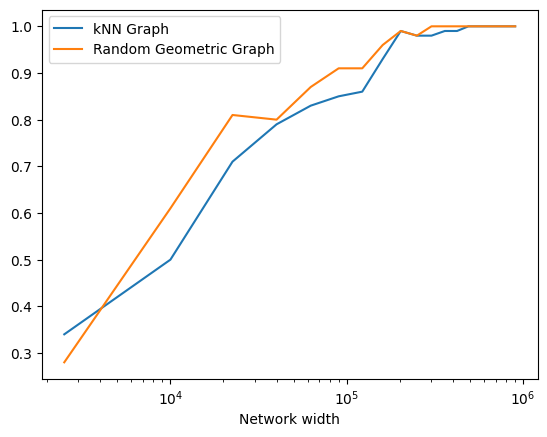

In [ ]:
# Plot results
plt.plot(np.square(np.arange(1,20)* 50), success_rate_kNN, label='kNN Graph')
plt.plot(np.square(np.arange(1,20)* 50), success_rate_r_neigh, label='Random Geometric Graph')
plt.xscale('log')
plt.xlabel('Network width')
plt.legend()

# D-dimensional Unit Ball

In [ ]:
def sample_unit_ball(n, dim):
    """Generate uniform samples from d-dimensional unit ball.

    Args:
        n (int): Number of samples.
        dim (int): Dimension.

    Returns:
        np.array: Samples.
    """
    x = np.random.randn(n, dim)
    x /= np.linalg.norm(x, axis=1, keepdims=True)  
    r = np.random.rand(n) ** (1/dim)         # scale for uniform volume
    x *= r[:, np.newaxis]
    return x

In [ ]:
# Generate samples
X = sample_unit_ball(50, dim=5)
gap_knn, gap_r_neigh =kth_gap(X=X,k=5), r_neighborhood_graph_gap(X=X,r=0.8)
gap_knn, gap_r_neigh

(np.float64(0.003375429495663068), np.float64(0.00029753215186731417))

In [ ]:
# Calculate lower bounds on width according to theoretical results
lower_bound_m(n=50, delta=0.05, epsilon=gap_knn), lower_bound_m(n=50, delta=0.05, epsilon=gap_r_neigh)

(np.float64(3804319.7095173798), np.float64(488121692.74696994))

In [ ]:
# Experimentally varify theoretical results
success_rate_kNN = []
success_rate_r_neigh = []
num_iterations = 100

for i in range(1,20):
    sqrt_m = 50 * i
    print(sqrt_m)
    avg_kNN = 0
    avg_r_neigh = 0
    for _ in tqdm(range(num_iterations)):
        # Initialize random matrix
        A = np.random.normal(0, 1/sqrt_m, size=(sqrt_m**2,5))

        # Compare kNN graphs
        if compare_kNN_graphs(X=X, A=A, k=5):
            avg_kNN +=1
        # Compare r-neighborhood graphs
        if compare_r_neighborhood_graphs(X=X, A=A,r=0.8):
            avg_r_neigh+=1

    print(avg_kNN/num_iterations, avg_r_neigh/num_iterations)
    success_rate_kNN.append(avg_kNN/num_iterations)
    success_rate_r_neigh.append(avg_r_neigh/num_iterations)

50


  0%|          | 0/100 [00:00<?, ?it/s]

0.02 0.01
100


  0%|          | 0/100 [00:00<?, ?it/s]

0.07 0.3
150


  0%|          | 0/100 [00:00<?, ?it/s]

0.27 0.53
200


  0%|          | 0/100 [00:00<?, ?it/s]

0.41 0.78
250


  0%|          | 0/100 [00:00<?, ?it/s]

0.62 0.93
300


  0%|          | 0/100 [00:00<?, ?it/s]

0.75 0.98
350


  0%|          | 0/100 [00:00<?, ?it/s]

0.76 0.98
400


  0%|          | 0/100 [00:00<?, ?it/s]

0.83 1.0
450


  0%|          | 0/100 [00:00<?, ?it/s]

0.87 1.0
500


  0%|          | 0/100 [00:00<?, ?it/s]

0.95 1.0
550


  0%|          | 0/100 [00:00<?, ?it/s]

0.97 1.0
600


  0%|          | 0/100 [00:00<?, ?it/s]

0.99 1.0
650


  0%|          | 0/100 [00:00<?, ?it/s]

0.95 1.0
700


  0%|          | 0/100 [00:00<?, ?it/s]

0.99 1.0
750


  0%|          | 0/100 [00:00<?, ?it/s]

0.98 1.0
800


  0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0
850


  0%|          | 0/100 [00:00<?, ?it/s]

0.99 1.0
900


  0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0
950


  0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0


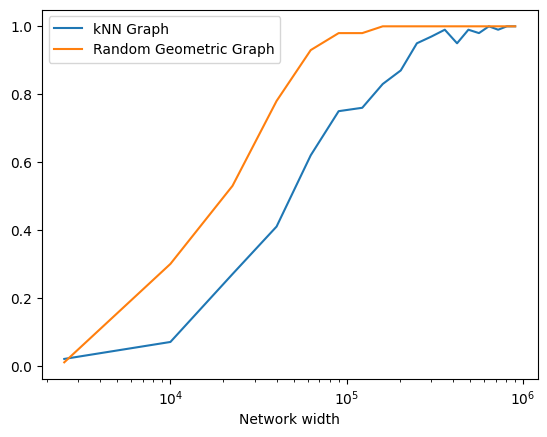

In [ ]:
# Plot results
plt.plot(np.square(np.arange(1,20)* 50), success_rate_kNN, label='kNN Graph')
plt.plot(np.square(np.arange(1,20)* 50), success_rate_r_neigh, label='Random Geometric Graph')
plt.xscale('log')
plt.xlabel('Network width')
plt.legend()